In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imageio

In [3]:
%load_ext Cython


In [4]:
img = imageio.imread('ct.png', pilmode='L')

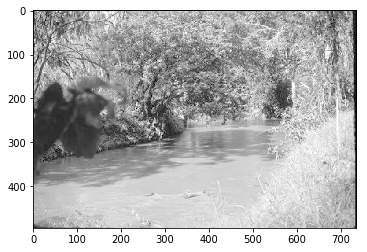

In [5]:
plt.imshow(img,cmap='gray')

##### coarseness 粗糙度

首先计算一些窗口的平均灰度
$$
A_k(x,y) = \sum_{i=x-2^{k-1}}^{x+2^{k-1}-1} \sum_{j=x-2^{k-1}}^{y+2^{k-1}-1} g(i,j)/2^{2k}
$$

其中$k=1,2,\dots,5$然后计算窗口之间的灰度差。

$$
\begin{align*}
E_{k,h}(x,y) &= \left\vert A_k(x+2^{k-1},y) - A_k(x-2^{k-1},y) \right\vert \\
E_{k,v}(x,y) &= \left\vert A_k(x,y+2^{k-1}) - A_k(x,y-2^{k-1}) \right\vert
\end{align*}
$$

显然灰度差小很可能是因为它还在同一个区域中，所以我们将试图找到最大化灰度绝对差的尺度水平作为粗糙度之衡量。

$$
S_{best}(x,y)=2^k
$$

整个图像的粗糙度定义为它各个可能窗口粗糙度之平均值

$$
F_{crs}=\frac{1}{m \times n}\sum_{i=1}^m \sum_{j=1}^n S_{best}(i,j)
$$

下面我采用不适用padding，也就是要减少相当多“样本”的方法。

In [37]:
def coarseness(g, max_k=5):
    m,n = g.shape
    A = np.zeros((max_k, m-2**max_k+1, n-2**max_k+1))
    S = np.zeros((m-2**max_k+1-2**max_k, n-2**max_k+1-2**max_k))
    
    for k in range(1,max_k+1):
        for x in range(2**(k-1), m-2**(max_k-1)):
            for y in range(2**(k-1), n-2**(max_k-1)):
                for i in range(x-2**(k-1),x+2**(k-1)):
                    for j in range(y-2**(k-1),y+2**(k-1)):
                        A[k-1, x-2**(max_k-1), y-2**(max_k-1)] += g[i,j]
                A[k-1, x-2**(max_k-1), y-2**(max_k-1)] /= 2**(2*k)
                
    for x in range(2**(max_k-1), m-2**max_k+1-2**max_k):
        for y in range(2**(max_k-1), n-2**max_k+1-2**max_k):
            best_k = 0
            best_s = 0
            for k in range(1, max_k+1):
                Eh = abs(A[k-1,x+2**(k-1),y] - A[k-1,x-2**(k-1),y])
                Ev = abs(A[k-1,x,y+2**(k-1)] - A[k-1,x,y-2**(k-1)])
                s = Eh + Ev
                if s > best_s:
                    best_k = k
                    best_s = s
                #SS[k-1,x-2**(max_k-1),y-2**(max_k-1)] = s
            S[x-2**(max_k-1),y-2**(max_k-1)] = 2**best_k

    F = np.mean(S)
    return F,S

In [7]:
''' ~ 7min
%%time 
coarseness(img, 5)
''' 

' ~ 7min\n%%time \ncoarseness(img, 5)\n'

In [8]:
sim = img[:200,:200]

In [38]:
%%time
F,S = coarseness(sim)
F

Wall time: 36.5 s


In [39]:
F

7.887793702381587

In [10]:
g = sim
max_k = 5

In [11]:
    m,n = g.shape
    A = np.zeros((max_k, m-2**max_k+1, n-2**max_k+1))
    S = np.zeros((m-2**max_k+1-2**max_k, n-2**max_k+1-2**max_k))
    
    for k in range(1,max_k+1):
        for x in range(2**(k-1), m-2**(max_k-1)):
            for y in range(2**(k-1), n-2**(max_k-1)):
                for i in range(x-2**(k-1),x+2**(k-1)):
                    for j in range(y-2**(k-1),y+2**(k-1)):
                        A[k-1, x-2**(max_k-1), y-2**(max_k-1)] += g[i,j]
                A[k-1, x-2**(max_k-1), y-2**(max_k-1)] /= 2**(2*k)


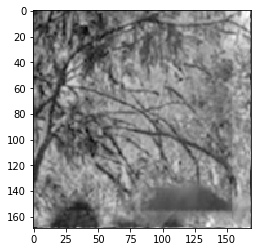

In [12]:
plt.imshow(A[0],cmap='gray')

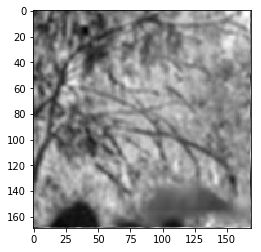

In [13]:
plt.imshow(A[1],cmap='gray')

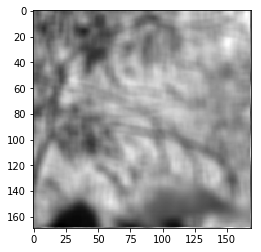

In [14]:
plt.imshow(A[2],cmap='gray')

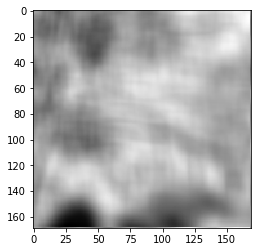

In [15]:
plt.imshow(A[3],cmap='gray')

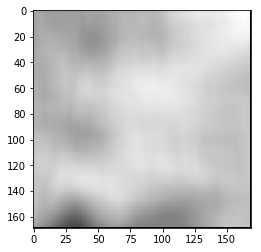

In [16]:
plt.imshow(A[4],cmap='gray')

In [17]:
    S = np.zeros((m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)))


In [18]:
SS = np.zeros((max_k,m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)))

In [19]:
    for x in range(2**(max_k-1), m-2**max_k+1-2**max_k):
        for y in range(2**(max_k-1), n-2**max_k+1-2**max_k):
            best_k = 0
            best_s = 0
            for k in range(1, max_k+1):
                Eh = abs(A[k-1,x+2**(k-1),y] - A[k-1,x-2**(k-1),y])
                Ev = abs(A[k-1,x,y+2**(k-1)] - A[k-1,x,y-2**(k-1)])
                s = Eh + Ev
                if s > best_s:
                    best_k = k
                    best_s = s
                SS[k-1,x-2**(max_k-1),y-2**(max_k-1)] = s
            S[x-2**(max_k-1),y-2**(max_k-1)] = 2**best_k
            


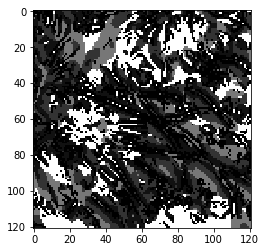

In [20]:
plt.imshow(S,cmap='gray')

In [21]:
SS[0]

array([[105.  ,  69.  ,  37.75, ...,  37.75,  15.5 ,  26.  ],
       [105.75,  58.5 ,  86.5 , ...,  41.25,  11.25,  31.25],
       [ 78.25,  29.  ,  98.25, ...,  34.5 ,  13.75,  39.  ],
       ...,
       [ 66.75,  88.25,  66.  , ...,  51.  ,  58.25,   6.5 ],
       [ 66.25,  94.75,  96.5 , ...,  36.25,  69.5 ,  52.  ],
       [ 64.  ,  48.75,  53.  , ...,  30.25,  48.  ,  58.75]])

In [22]:
SS[1]

array([[78.5625, 45.0625, 13.5625, ..., 14.375 ,  8.0625,  4.75  ],
       [71.5625, 26.6875, 36.4375, ..., 11.    ,  1.4375,  8.9375],
       [35.75  , 24.375 , 73.25  , ..., 11.875 ,  9.9375, 14.9375],
       ...,
       [68.8125, 76.125 , 70.375 , ..., 47.5625, 31.75  ,  4.6875],
       [47.6875, 70.3125, 78.5625, ..., 57.75  , 53.5625, 32.6875],
       [36.375 , 50.0625, 68.75  , ..., 67.4375, 71.5625, 59.5625]])

In [23]:
SS[2]

array([[ 6.421875,  3.203125,  1.921875, ..., 14.578125, 16.359375,
        16.1875  ],
       [16.40625 ,  7.78125 , 11.71875 , ..., 24.34375 , 27.328125,
        26.625   ],
       [14.46875 , 15.609375, 23.78125 , ..., 29.671875, 32.5625  ,
        31.890625],
       ...,
       [55.875   , 72.390625, 77.734375, ..., 69.296875, 59.296875,
        48.90625 ],
       [43.3125  , 63.453125, 73.375   , ..., 82.5625  , 72.203125,
        62.3125  ],
       [24.109375, 45.609375, 59.625   , ..., 91.78125 , 83.1875  ,
        73.953125]])

In [24]:
SS[:,-2,-2]

array([69.5       , 53.5625    , 72.203125  , 77.44140625, 30.62402344])

In [25]:
from collections import Counter

In [26]:
Counter(np.ravel(S))

Counter({2.0: 4607, 4.0: 3480, 32.0: 2483, 8.0: 2460, 16.0: 1611})

(array([8087.,    0., 2460.,    0., 1611.,    0.,    0.,    0.,    0.,
        2483.]),
 array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29., 32.]),
 <a list of 10 Patch objects>)

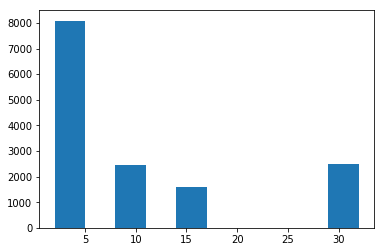

In [27]:
plt.hist(np.ravel(S))

In [28]:
sim

Image([[  0,  43,  46, ...,   0,   0,   0],
       [ 39,  43,  39, ...,  28,   0,   0],
       [ 50,  34,  21, ..., 123, 110, 127],
       ...,
       [ 39,  89, 107, ..., 136, 153, 159],
       [ 53,  82, 101, ..., 131, 145, 149],
       [ 66,  84,  96, ..., 156, 139, 122]], dtype=uint8)

In [29]:
%%cython --annotate

import numpy as np
cimport numpy as np

def coarseness_cython(unsigned char[:, :] g, int m, int n, int max_k, float[:,:,:] SS):
    #m,n = g.shape
    cdef int k,x,y,i,j,best_k,
    cdef float Eh,Ev,s,best_s,ss
    #cdef np.ndarray[float, ndim=3] A = np.empty((max_k, m-2**max_k+1, n-2**max_k+1), dtype=np.float32)
    cdef float[:,:,:] A = np.zeros((max_k, m-2**max_k+1, n-2**max_k+1), dtype=np.float32)
    #cdef np.ndarray[float, ndim=2] S = np.empty((m-2**max_k+1-2**max_k, n-2**max_k+1-2**max_k))
    
    for k in range(1,max_k+1):
        for x in range(2**(k-1), m-2**(max_k-1)):
            for y in range(2**(k-1), n-2**(max_k-1)):
                for i in range(x-2**(k-1),x+2**(k-1)):
                    for j in range(y-2**(k-1),y+2**(k-1)):
                        A[k-1, x-2**(max_k-1), y-2**(max_k-1)] += g[i,j]
                A[k-1, x-2**(max_k-1), y-2**(max_k-1)] /= 2**(2*k)
    
    ss=0.0
    for x in range(2**(max_k-1), m-2**max_k+1-2**max_k):
        for y in range(2**(max_k-1), n-2**max_k+1-2**max_k):
            best_k = 0
            best_s = 0.0
            for k in range(1, max_k+1):
                Eh = abs(A[k-1,x+2**(k-1),y] - A[k-1,x-2**(k-1),y])
                Ev = abs(A[k-1,x,y+2**(k-1)] - A[k-1,x,y-2**(k-1)])
                s = Eh + Ev
                if s > best_s:
                    best_k = k
                    best_s = s
                    
                #BS[x-2**(max_k-1),y-2**(max_k-1)] = best_s
                #BK[x-2**(max_k-1),y-2**(max_k-1)] = best_k
                SS[k-1,x-2**(max_k-1),y-2**(max_k-1)] = s
            #S[x-2**(max_k-1),y-2**(max_k-1)] = 2**best_k
            ss += 2**best_k
    
    #F = np.mean(S)
    #s /= ( m-2**max_k+1-2**max_k - 2**(max_k-1))*( n-2**max_k+1-2**max_k - 2**(max_k-1))
    return ss / (( m-2**max_k+1-2**max_k - 2**(max_k-1))*( n-2**max_k+1-2**max_k - 2**(max_k-1)))
    
    #return s

In [30]:
( m-2**max_k+1-2**max_k - 2**(max_k-1))*( n-2**max_k+1-2**max_k - 2**(max_k-1))

14641

In [31]:
max_k = 5
m,n = sim.shape
SS = np.zeros((max_k,m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)), dtype=np.float32)
#BK = np.zeros((m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)), dtype=np.int32)
#BS = np.zeros((m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)), dtype=np.float32)


In [32]:
%%time
coarseness_cython(sim, sim.shape[0], sim.shape[1], 5, SS)

Wall time: 144 ms


10.111741065979004

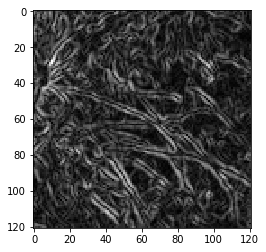

In [33]:
plt.imshow(SS[0], cmap='gray')

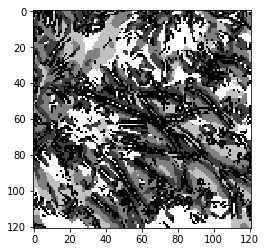

In [34]:
plt.imshow(np.argmax(SS, axis=0), cmap='gray')

In [35]:
np.mean(2**(np.argmax(SS, axis=0)+1))

10.111741001297725

In [40]:
max_k = 5
m,n = img.shape
SS = np.zeros((max_k,m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)), dtype=np.float32)


In [41]:
%%time
coarseness_cython(img, img.shape[0], img.shape[1], 5, SS)

Wall time: 1.62 s


16.42825698852539

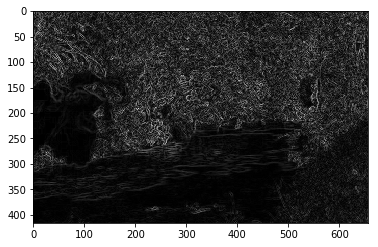

In [42]:
plt.imshow(SS[0], cmap='gray')

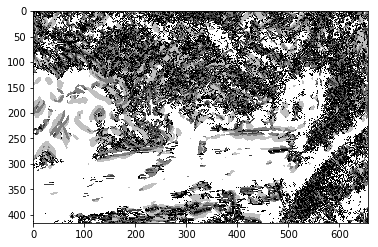

In [43]:
plt.imshow(np.argmax(SS, axis=0), cmap='gray')

In [44]:
imageio.imsave('coarseness.png', np.argmax(SS, axis=0))

In [48]:
night_img = imageio.imread('IMG_20181126_221904_HHT.jpg', pilmode='L')

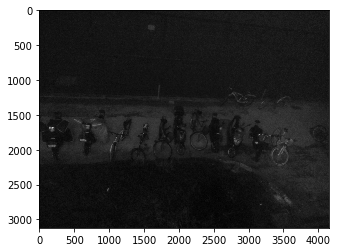

In [50]:
plt.imshow(night_img,cmap='gray')

In [51]:
def coarseness_cython_helper(img, max_k=5):
    m,n = img.shape
    SS = np.zeros((max_k,m-2**max_k+1-2**max_k - 2**(max_k-1), n-2**max_k+1-2**max_k - 2**(max_k-1)), dtype=np.float32)
    coarse = coarseness_cython(img, img.shape[0], img.shape[1], 5, SS)
    return coarse,SS


In [57]:
%%time
coarse, SS = coarseness_cython_helper(night_img)

Wall time: 1min 4s


In [58]:
imageio.imsave('coarseness_night.png', np.argmax(SS, axis=0))

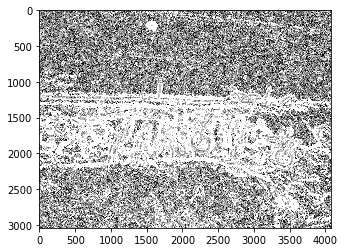

In [59]:
plt.imshow(np.argmax(SS, axis=0),cmap='gray')

In [60]:
%%time
coarse2, SS2 = coarseness_cython_helper(img)

Wall time: 1.65 s
